# __Model training__

In [1]:

import numpy as np # to work with arrays
import pandas as pd # to work with dataframes
import torch # to work with tensors
from IPython.display import Audio # to play audio
from handler import get_features, stack_features, DropDupCorrScal # to extract features from audio files

# import librosa as lb # to work with audio files
# from librosa import feature as lbf # to extract features from audio files

import matplotlib.pyplot as plt # to plot graphs
plt.style.use('dark_background') # to set style of graphs
import seaborn as sns # to plot graphs
sns.set(style='dark', palette='bright') # to set style and palette of graphs

from sklearn.model_selection import train_test_split # to split data into train and test sets
from sklearn.pipeline import Pipeline # to create a pipeline of transformers
# from sklearn.compose import ColumnTransformer # to preprocess columns of a dataframe
# from sklearn.base import BaseEstimator, TransformerMixin # to create custom transformers    
from sklearn.preprocessing import MinMaxScaler # to scale features
from sklearn.model_selection import GridSearchCV # to perform grid search
# from feature_engine.selection import DropDuplicateFeatures # to drop duplicate features
# from feature_engine.selection import SmartCorrelatedSelection # to drop correlated features
from sklearn.metrics import accuracy_score # to calculate accuracy
from sklearn.linear_model import  LogisticRegression # to create a logistic regression model

from torch.utils.data import Dataset, DataLoader # to create a custom dataset of tensors
from torch import nn # to create neural network layers
# import torchvision.transforms as transforms # to transform data
from torch import optim # to create an optimizer    
# from torch import sigmoid, relu, tanh # to create activation functions 

from joblib import dump, load # to save and load the model
import pickle # to save and load the model

# Suppress all warnings
import warnings # to suppress warnings
warnings.filterwarnings("ignore")

---
##### *__Extract features from voice commands__*
---

In [133]:
# Download the dataset as lists  
# 0-2499: forward, 2500-4999: backward, 5000-7499: stop, 7500-9999: left, 10000-12499: right
# 0: forward, 1: backward, 2: stop, 3: left, 4: right
try:
    x = torch.load('../data/tensor_x.pt')
    y = torch.load('../data/tensor_y.pt')
except Exception as e:
    print(f"Error loading tensor: {e}")

In [134]:
# check the dataset after loading
idx = 2500
display(Audio(x[idx], rate=24000)), y[idx]

(None, 1)

In [135]:
# create a dictionary of features and their number
features_number = { key: value.shape[0] for key, value in get_features(x[0].numpy()).items() }
# create a list of columns names of each feature for the dataframe
features_columns = [ key if value == 1 else key + '_' + str(i) for key, value in features_number.items() for i in range(value) ]
features_columns[:7], len(features_columns)

(['stft_0', 'stft_1', 'stft_2', 'stft_3', 'stft_4', 'stft_5', 'stft_6'], 217)

In [137]:
# преобразуем полученные признаки в данные для обучения модели
X_data = np.array([stack_features(get_features(np.array(i))) for i in x]).astype('float32')

In [27]:
# create a dataframe with features and target
df = pd.DataFrame(X_data, columns=features_columns)
df['target'] = y # add target column
# save the dataframe as a csv file
df.to_csv('../data/features.csv', index=False, sep=',')

In [247]:
# Download the test dataset as lists  
# 0: forward, 1: backward, 2: stop, 3: left, 4: right
try:
    x = torch.load('../data/test_x.pt')
    y = torch.load('../data/test_y.pt')
except Exception as e:
    print(f"Error loading tensor: {e}")

In [248]:
# check the dataset after loading
idx = 7
display(Audio(x[idx], rate=24000)), y[idx]

(None, 2)

In [140]:
# create a dictionary of features and their number
features_number = { key: value.shape[0] for key, value in get_features(x[0].numpy()).items() }
# create a list of columns names of each feature for the dataframe
features_columns = [ key if value == 1 else key + '_' + str(i) for key, value in features_number.items() for i in range(value) ]
features_columns[:7], len(features_columns)

(['stft_0', 'stft_1', 'stft_2', 'stft_3', 'stft_4', 'stft_5', 'stft_6'], 217)

In [141]:
# transform features into data for model testing
X_data = np.array([stack_features(get_features(np.array(i))) for i in x]).astype('float32')

In [142]:
# create a dataframe with features and target
df = pd.DataFrame(X_data, columns=features_columns)
df['target'] = y # add target column
# save the dataframe as a csv file
df.to_csv('../data/features_test.csv', index=False, sep=',')

---
##### *__Train baseline model for voice command classification__*
---

In [143]:
df = pd.read_csv('../data/features.csv').drop_duplicates() # load the dataframe and drop duplicates
df.reset_index(drop=True, inplace=True) # reset the index  
df.shape # check the shape of the dataframe

(6761, 218)

In [144]:
df_test = pd.read_csv('../data/features_test.csv').drop_duplicates() # load the dataframe and drop duplicates
df_test.reset_index(drop=True, inplace=True) # reset the index  
df_test.shape # check the shape of the dataframe

(28, 218)

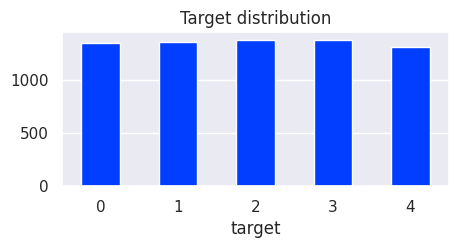

In [145]:
plt.figure(figsize=(5, 2)) # set the size of the graph 
ax = df.target.value_counts().sort_index().plot(kind='bar', title='Target distribution', rot=0) # plot the graph
ax.yaxis.grid(True) # show horizontal grid
plt.show() # show the graph

In [146]:
# check the number of missing values and constant features in the dataframe
print(f'the number of missing values: {df.isna().sum().sum()}')
df.nunique().sort_values()[:3] # check the number of unique values in each column

the number of missing values: 0


target        5
rolloff    5499
zcr        6269
dtype: int64

In [151]:
X_train, X_val, y_train, y_val = train_test_split(df.drop('target', axis=1), df.target, test_size=0.1, shuffle=True, random_state=42) # split the dataframe into train and test sets
X_test, y_test = df_test.drop('target', axis=1), df_test.target # create data for testing the model
features = X_train.columns.tolist() # create a list of features
X_train.shape, X_val.shape # check the shape of the train and test sets    

((6084, 217), (677, 217))

In [119]:
processor = DropDupCorrScal() # initialize the transformer  
processor.fit(X_train) # fit the transformer    
dump(processor, '../models/processor.joblib') # save the transformer  

['../models/processor.joblib']

In [153]:
processor = load('../models/processor.joblib') # load the transformer

In [154]:
X_train, X_val, X_test = processor.transform(X_train), processor.transform(X_val), processor.transform(X_test) # transform the features   
X_train.shape, X_val.shape , X_test.shape # check the shape of the train and test sets

((6084, 112), (677, 112), (28, 112))

In [122]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()), # initialize the transformer for scaling features
    ('model', LogisticRegression(multi_class='multinomial', random_state=42))
    ]) # initialize the pipeline

# Define the parameter grid
param_grid = {
    'model__C': [*range(10, 100, 10)],
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none '],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],

}

# Create the grid search object
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

model = grid_search.best_estimator_ # save the best model

Best parameters: {'model__C': 90, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best score: 0.9564423139298533


In [155]:
dump(model, '../models/model_sklearn.joblib') # save the model
model = load('../models/model_sklearn.joblib') # load the model

In [156]:
# Calculate the accuracy score
print(f'accuracy score on the validation data: {round(accuracy_score(y_val, model.predict(X_val)), 3)}')
print(f'accuracy_score on the test data: {round(accuracy_score(y_test, model.predict(X_test)), 3)}')

accuracy score on the validation data: 0.959
accuracy_score on the test data: 0.357


In [157]:
print(f'{model.predict(X_test)} - prediction') # predict the target
print(y_test.values) # check the target

[3 3 2 4 3 3 4 3 2 3 3 3 4 4 4 3 4 3 3 4 4 4 4 4 3 4 2 4] - prediction
[0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4]


---
##### *__Train neural network model for voice command classification with PyTorch__*
---

*__Logistic Regression with PyTorch :__*

In [201]:
scaler = MinMaxScaler() # initialize the transformer for scaling features
scaler.fit(X_train) # fit the transformer
# join the train and test sets and convert them to tensors
data_x = torch.from_numpy(scaler.transform(pd.concat([X_train, X_val]))).type(torch.FloatTensor)
data_y = torch.from_numpy(np.concatenate((y_train, y_val))).type(torch.LongTensor)
# split the dataset into train and test sets
train_x, val_x, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2, shuffle=False, random_state=42)
train_x.shape, val_x.shape, train_y.shape, val_y.shape # check the shape of the train and test sets

(torch.Size([5408, 112]),
 torch.Size([1353, 112]),
 torch.Size([5408]),
 torch.Size([1353]))

In [202]:
test_x = torch.from_numpy(scaler.transform(X_test)).type(torch.FloatTensor) # convert the test set to a tensor
test_y = torch.from_numpy(y_test.values).type(torch.LongTensor) # convert the test target to a tensor
test_x.shape, test_y.shape # check the shape of the test set

(torch.Size([28, 112]), torch.Size([28]))

In [203]:
class AudioDataset(Dataset):
    '''
    the class creates a custom dataset of tensors
    '''
    def __init__(self, X, y, transform=None):
        '''
        X: features
        y: target
        '''
        self.X = X
        self.y = y

    def __len__(self):
        '''
        the function returns the length of the dataset
        '''
        return len(self.X)

    def __getitem__(self, idx):
        '''
        the function returns a sample from the dataset
        idx: index of the sample
        return: sample
        '''
        return self.X[idx], self.y[idx]

In [204]:
train_data = AudioDataset(train_x, train_y) # create a dataset
print(train_data[0][0].size(),train_data[0][0].type(), train_data[0][1].type(), len(train_data)) # check the first sample
train_loader = DataLoader(train_data, batch_size=100, shuffle=True) # create a dataloader

val_data = AudioDataset(val_x, val_y) # create a dataset 
print(val_data[0][0].size(), val_data[0][1].type(), len(val_data)) # check the first sample
val_loader = DataLoader(val_data, batch_size=100, shuffle=True) # create a dataloader

torch.Size([112]) torch.FloatTensor torch.LongTensor 5408
torch.Size([112]) torch.LongTensor 1353


In [205]:
in_size, out_size = train_data[0][0].size()[0], np.unique(data_y).size # get the input and output sizes
print(f'number of parameters: {in_size}\nnumber of classes: {out_size}')
model = nn.Linear(in_size, out_size) # create a model
criterion = nn.CrossEntropyLoss() # create a loss function
optimizer = optim.SGD(model.parameters(), lr=1) # create an optimizer    
epochs = 5000 # set the number of epochs

LOSS, accuracy = {'train': [], 'val': []}, [] # create a list for the loss

number of parameters: 112
number of classes: 5


In [166]:
for epoch in range(epochs):
    lst, total, correct = [], 0, 0 # create a list for the loss, total number of samples and correct predictions

    for x, y in train_loader: # iterate over the train loader
        optimizer.zero_grad() # zero the gradients
        loss = criterion(model(x), y) # calculate the loss
        loss.backward() # backpropagate the loss
        optimizer.step() # update the weights
        lst.append(loss.item()) # append the loss to the list
    if epoch % 200 == 0: # grab the loss every 200 epochs
        LOSS['train'].append(sum(lst)/len(lst)) # calculate the average loss
        lst = [] # clean the list

    for x, y in val_loader: # calculate the loss on the validation set
        lst.append(criterion(model(x), y).item()) # calculate the loss
        _, predicted = torch.max(model(x).data, 1) # get the predictions
        total += y.size(0) # update the total number of samples
        correct += (predicted == y).sum().item() # update the correct predictions
    if epoch % 200 == 0: # grab the loss every 200 epochs
        LOSS['val'].append(sum(lst)/len(lst)) # calculate the average loss
        accuracy.append(correct / total)  # append calculated the accuracy

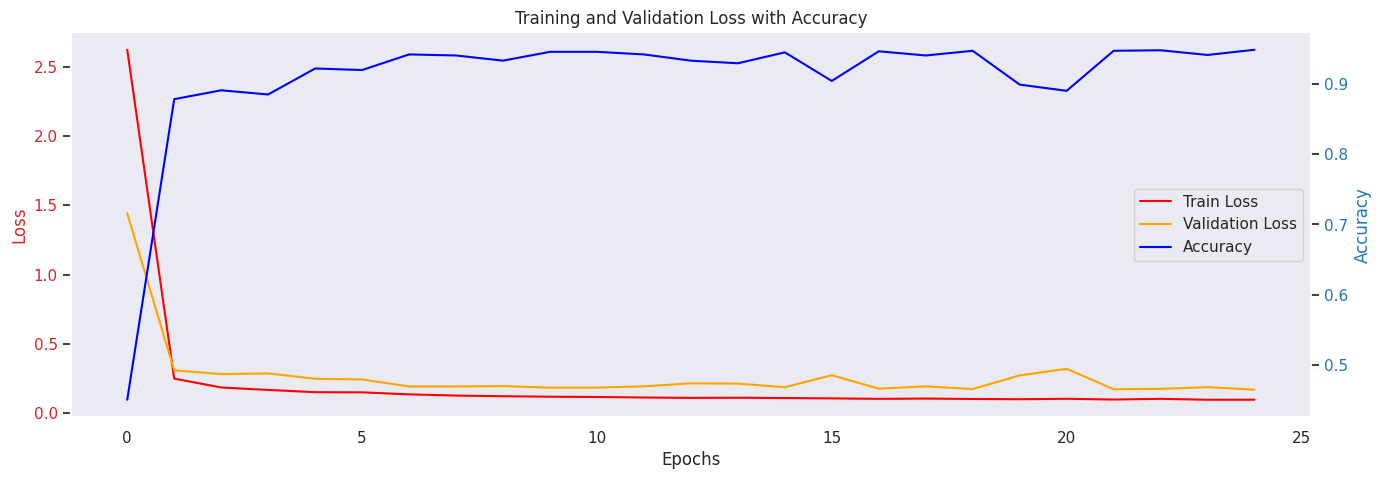

In [168]:
# Create a dataframe for the loss values
df_loss = pd.DataFrame({'Train Loss': LOSS['train'], 'Validation Loss': LOSS['val']})

# Create a dataframe for the accuracy values
df_accuracy = pd.DataFrame({'Accuracy': accuracy})

# Plot the loss and accuracy values
fig, ax1 = plt.subplots(figsize=(16, 5)) # set the size of the graph 

# Plot the loss values
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(df_loss.index, df_loss['Train Loss'], color='red', label='Train Loss')
ax1.plot(df_loss.index, df_loss['Validation Loss'], color='orange', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for accuracy
ax2 = ax1.twinx()

# Plot the accuracy values
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(df_accuracy.index, df_accuracy['Accuracy'], color='blue', label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Create a common legend and place it in the middle from the right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.title('Training and Validation Loss with Accuracy')
plt.show()


In [197]:
# Calculate the accuracy score
_, predicted =torch.max(model(test_x).data, 1)
print(f'accuracy: {round((predicted == test_y).sum().item() / test_y.size(0), 3)}')
print(*predicted.data.numpy(), '- prediction')
print(*test_y.data.numpy())

accuracy: 0.357
3 3 2 4 3 3 4 3 3 3 3 2 4 4 4 3 4 3 3 4 4 4 4 4 3 4 2 4 - prediction
0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4


*__Nueral Network :__*

In [206]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=10):
    """
    the function accepts the model, loss function, train and validation loaders, optimizer and number of epochs
    model: neural network model
    criterion: loss function
    train_loader: train loader
    validation_loader: validation loader
    optimizer: optimizer
    epochs: number of epochs
    """
    metrics = {'training_loss': [],'validation_accuracy': []} # create a dictionary for the loss and accuracy values
    for epoch in range(epochs): # iterate over the epochs
        total_loss = 0 # initialize the loss
        for x, y in train_loader: # iterate over the train loader
            optimizer.zero_grad() # zero the gradients
            loss = criterion(model(x), y) # calculate the loss
            loss.backward() # backpropagate the loss
            optimizer.step() # update the weights
            total_loss += loss.data.item() # update the loss for every iteration

        metrics['training_loss'].append(total_loss / len(train_loader)) # calculate the average loss
        correct = 0 # initialize the correct predictions

        for x, y in validation_loader: # iterate over the validation loader
            _, label = torch.max(model(x), 1) # get the predictions
            correct += (label == y).sum().item() # update the correct predictions

        accuracy = 100 * (correct / len(validation_loader.dataset)) # calculate the accuracy
        metrics['validation_accuracy'].append(accuracy) # append the accuracy to the list
        
    return metrics

In [209]:
# create nueral networks
hidden_size = 5
model = nn.Sequential(
    nn.Linear(112, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, 5)
)
criterion = nn.CrossEntropyLoss() # create a loss function 
optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

In [210]:
metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100) # train the model

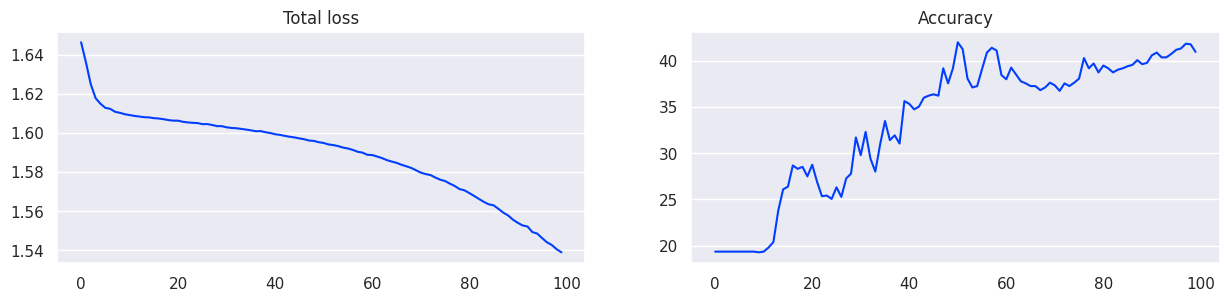

In [211]:
fig = plt.figure(figsize=(15, 3)) # set the size of the graph
plt.subplot(1, 2, 1) # create a subplot
plt.plot(metrics['training_loss']) # plot the loss
plt.title('Total loss') # set the title
plt.grid(axis='y') # show horizontal grid

plt.subplot(1, 2, 2) # create a subplot
plt.plot(metrics['validation_accuracy']) # plot the accuracy
plt.title("Accuracy") # set the title
plt.grid(axis='y') # show horizontal grid

plt.show() # show the graph

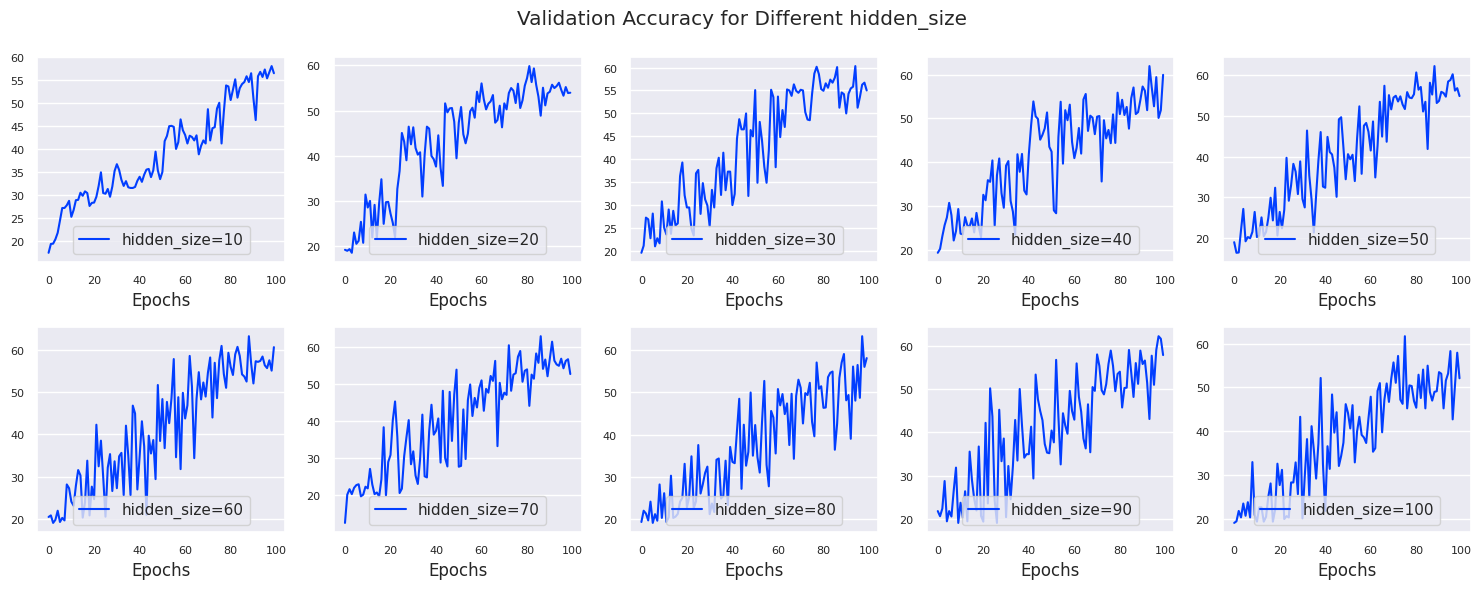

In [212]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) # set the size of the graph
fig.suptitle('Validation Accuracy for Different hidden_size') # set the title

for i, ax in enumerate(axes.flatten()): # iterate over the subplots
    hidden_size = (i + 1) * 10 # set the hidden size
    # create nueral networks
    model = nn.Sequential(
        nn.Linear(112, hidden_size),
        nn.Sigmoid(),
        nn.Linear(hidden_size, 5)
    )
    criterion = nn.CrossEntropyLoss() # create a loss function 
    optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

    metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100) # train the model
    
    ax.plot(metrics['validation_accuracy'], label=f'hidden_size={hidden_size}') # plot the accuracy
    ax.set_xlabel('Epochs') # set the label for the x-axis
    ax.legend(loc='lower center') # show the legend
    ax.grid(axis='y')  # Add horizontal grid
    ax.tick_params(axis='both', which='both', labelsize=8)  # Set tick label size

plt.tight_layout() # set the layout of the graph
plt.show() # show the graph

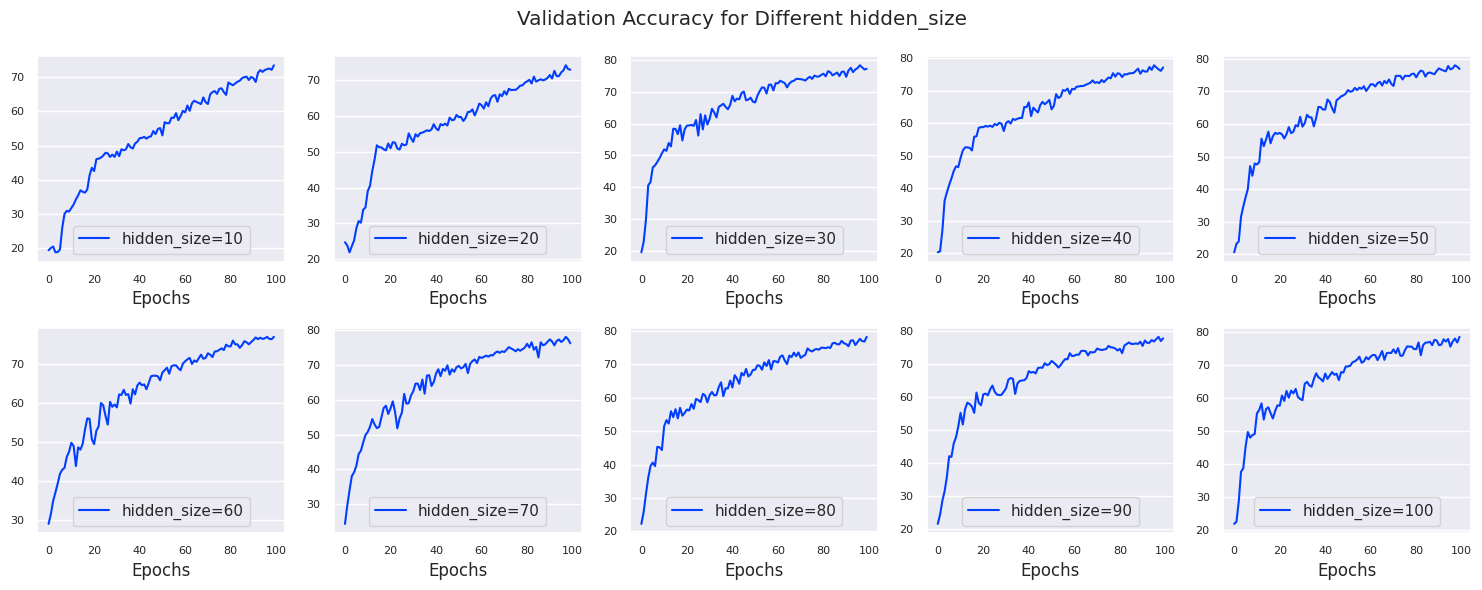

In [213]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) # set the size of the graph 
fig.suptitle('Validation Accuracy for Different hidden_size') # set the title

for i, ax in enumerate(axes.flatten()): # iterate over the subplots
    hidden_size = (i + 1) * 10 # set the hidden size
    # create nueral networks
    model = nn.Sequential(
        nn.Linear(112, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 5)
    )
    criterion = nn.CrossEntropyLoss() # create a loss function 
    optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

    metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100) # train the model
    
    ax.plot(metrics['validation_accuracy'], label=f'hidden_size={hidden_size}') # plot the accuracy
    ax.set_xlabel('Epochs') # set the label for the x-axis
    ax.legend(loc='lower center') # show the legend
    ax.grid(axis='y')  # Add horizontal grid
    ax.tick_params(axis='both', which='both', labelsize=8)  # Set tick label size

plt.tight_layout() # set the layout of the graph
plt.show() # show the graph

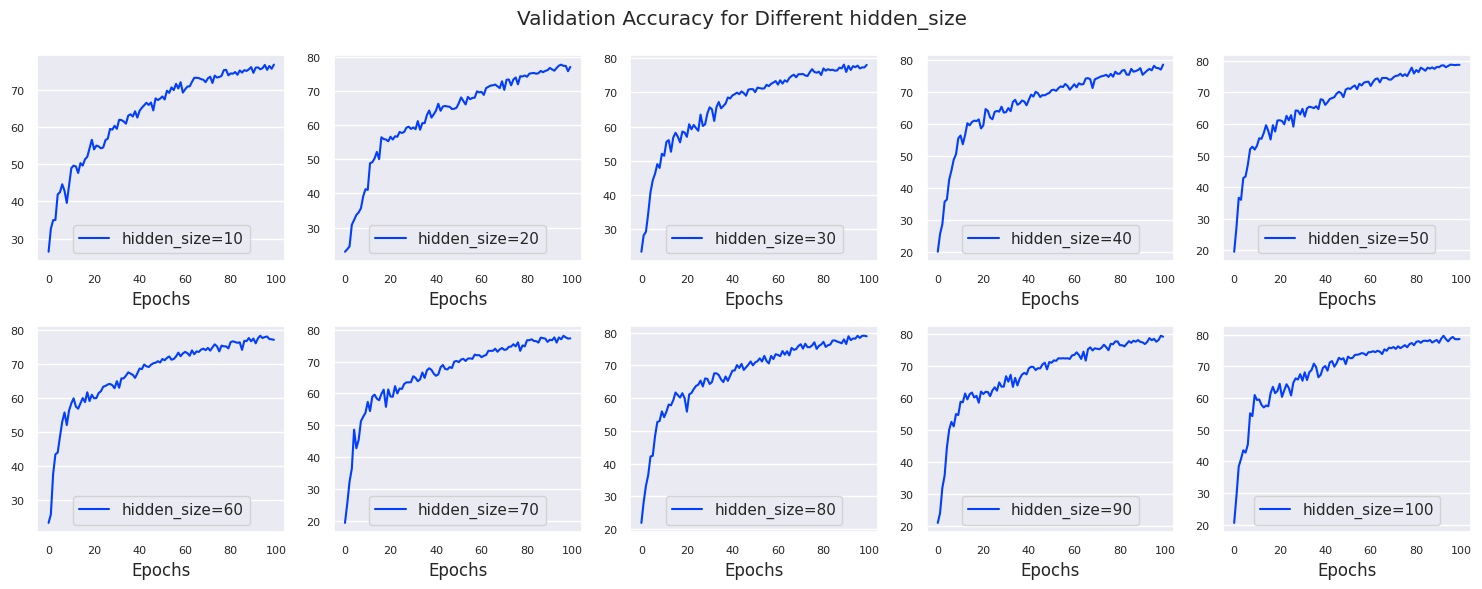

In [215]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) # set the size of the graph
fig.suptitle('Validation Accuracy for Different hidden_size') # set the title

for i, ax in enumerate(axes.flatten()): # iterate over the subplots
    hidden_size = (i + 1) * 10 # set the hidden size
    # create nueral networks
    model = nn.Sequential(
        nn.Linear(112, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, 5)
    )
    criterion = nn.CrossEntropyLoss() # create a loss function 
    optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

    metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100) # train the model
    
    ax.plot(metrics['validation_accuracy'], label=f'hidden_size={hidden_size}') # plot the accuracy
    ax.set_xlabel('Epochs') # set the label for the x-axis
    ax.legend(loc='lower center') # show the legend
    ax.grid(axis='y')  # Add horizontal grid
    ax.tick_params(axis='both', which='both', labelsize=8)  # Set tick label size

plt.tight_layout() # set the layout of the graph
plt.show() # show the graph


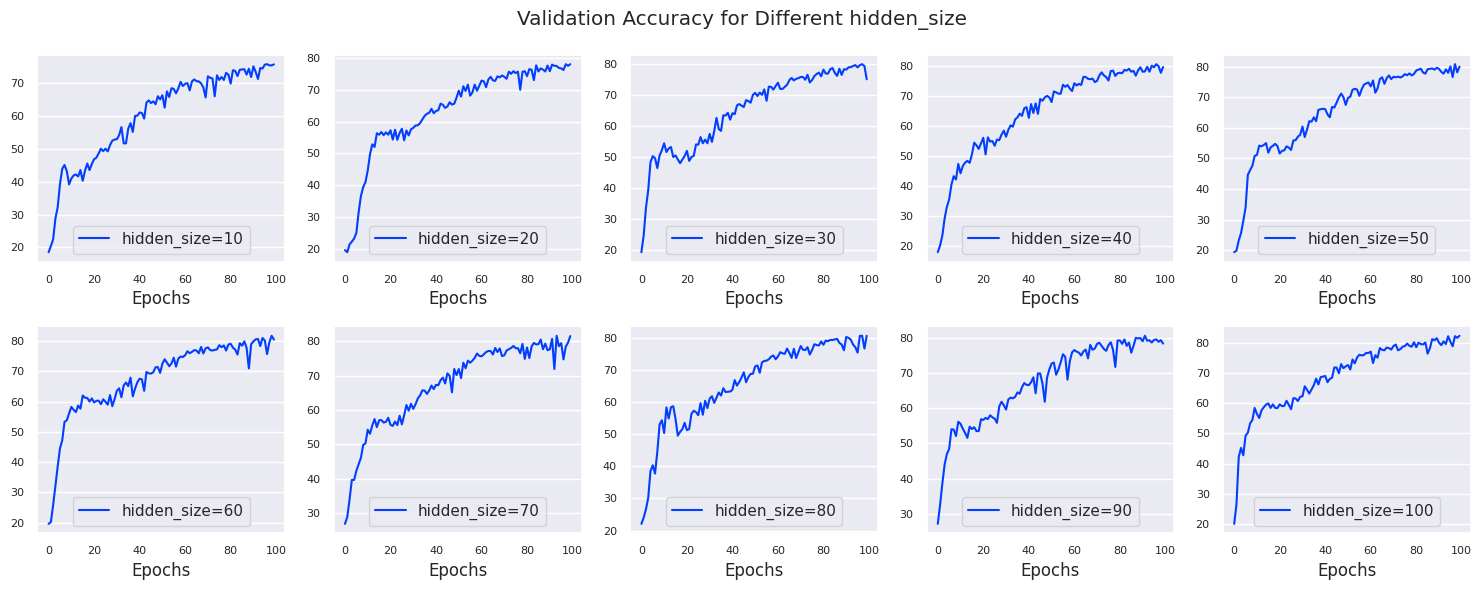

In [217]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Validation Accuracy for Different hidden_size')

for i, ax in enumerate(axes.flatten()):
    hidden_size = (i + 1) * 10
    model = nn.Sequential(
        nn.Linear(112, 100),
        nn.Tanh(),
        nn.Linear(100, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, 5)
    )
    criterion = nn.CrossEntropyLoss() # create a loss function 
    optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

    metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100)
    
    ax.plot(metrics['validation_accuracy'], label=f'hidden_size={hidden_size}')
    ax.set_xlabel('Epochs')
    ax.legend(loc='lower center')
    ax.grid(axis='y')  # Add horizontal grid
    ax.tick_params(axis='both', which='both', labelsize=8)  # Set tick label size

plt.tight_layout()
plt.show()


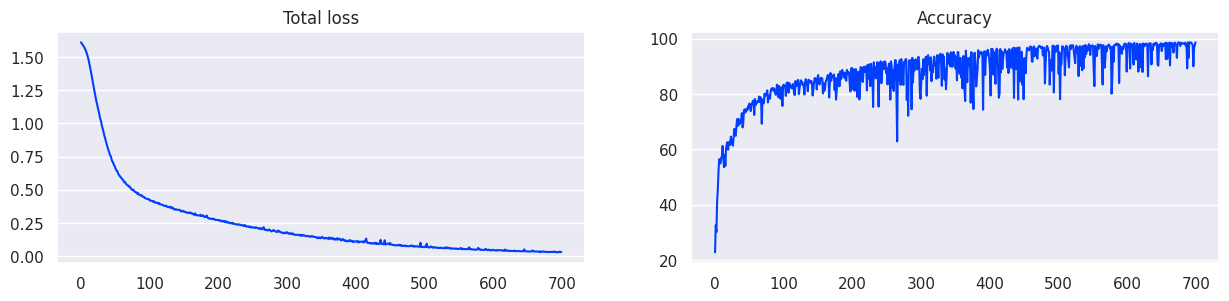

98.66962305986696
tensor([ 0.0692, -0.0031,  0.0388,  0.0417, -0.0911, -0.0598, -0.0170,  0.0195,
         0.0199,  0.0485])


In [226]:
# create nueral networks
model = nn.Sequential(
    nn.Linear(112, 200),
    nn.ReLU(),
    nn.Linear(200, 500),
    nn.Tanh(),
    nn.Linear(500, 5)
)
criterion = nn.CrossEntropyLoss() # create a loss function 
optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=700)

fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_loss'])
plt.title('Total loss')
plt.grid(axis='y')  
plt.subplot(1, 2, 2)
plt.plot(metrics['validation_accuracy'])
plt.title("Accuracy")
plt.grid(axis='y')
plt.show()

print(metrics['validation_accuracy'][-1])
print(model.state_dict()['0.weight'][0][:10])

In [227]:
# Calculate the accuracy score
_, predicted =torch.max(model(test_x).data, 1)
print(f'accuracy: {round((predicted == test_y).sum().item() / test_y.size(0), 3)}')
print(*predicted.data.numpy(), '- prediction')
print(*test_y.data.numpy())

accuracy: 0.429
3 3 2 4 3 3 4 3 2 2 3 2 4 4 4 3 4 3 3 4 4 4 4 4 3 4 2 4 - prediction
0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4


In [230]:
# Save the model
with open('../models/model_nueral.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model
with open('../models/model_nueral.pkl', 'rb') as f:
    model = pickle.load(f)

In [233]:
# Calculate the accuracy score again to check if the model is loaded correctly
_, predicted =torch.max(model(test_x).data, 1)
print(f'accuracy: {round((predicted == test_y).sum().item() / test_y.size(0), 3)}')
print(*predicted.data.numpy(), '- prediction')
print(*test_y.data.numpy())

accuracy: 0.429
3 3 2 4 3 3 4 3 2 2 3 2 4 4 4 3 4 3 3 4 4 4 4 4 3 4 2 4 - prediction
0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4


In [246]:
model(test_x[2]).argmax().item()

2